In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score

# скачиваем изображения ввиде эмбедингов
with open('image_embeddings.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings
# скачиваем датасет
df = pd.read_csv('data_split_into_classes.csv', index_col= 0)
df

,image_id,title
item_id,,
928428250447,9930449149,Беговая дорожка laufstein corsa automatik
172952000262,1770341493,Эллиптический тренажер Torneo Vento C-208
1064720000255,11289835148,Эллиптический тренажер
660092751953,5126102753,Гантели по 10 кг каждая
258603750759,2318932240,Kettler Delta XL
...,...,...
403658750648,3335234348,Housefir
32427250428,898227519,Силовой комплекс HouseFit 42110
267083000211,2301454396,Степпер decathlon domyos ST320 purple


# Анализ данных
После анализа данных можно прийти к выводу о том, что:
- некоторый инвентарь правильно класстеризуется
- главной задачей является определить правильное число класстеров
- также были выявлены следующие уникальные объекты:

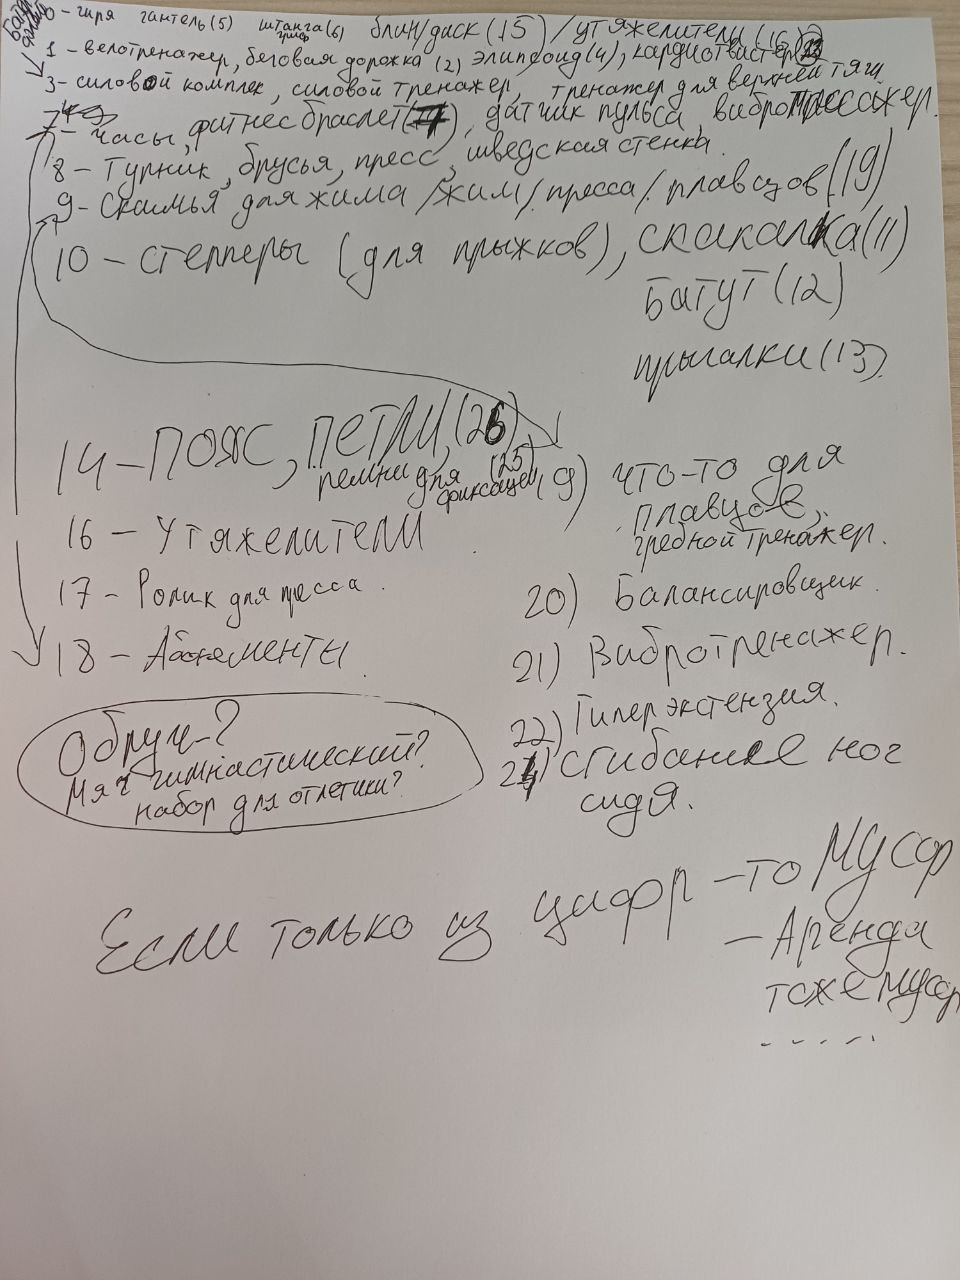

# Гипотеза о том какие объекты можно объединить в класстер:

1) `гиря / гантель / штанга / гриф / блины / диски / утяжелители` <- класстер базовых вещей для тренировки верхней части тела
2) `велотренажер / беговая дорожка / элипсоид / кардиотвистер` <- класстер "кардио тренировок"
3) `силовой комплекс / силовой тренажер / тренажер для верхней тяги` <- класстер в котором больлшие тренажеры и которые будет трудно скорее всего перевозить
4) `часы / абонементы / фитнес браслет / датчик пульса / выбиромассажер / выборотренажер` - доп инвентарь для тренировок + реабилитация <- т.е. класстер отвечающий за анализ качества тренировок и реабилитации
5) `турник / брусья / пресс / шведская стенка` <- базовый инвентарь без веса
6) `скамья для жима / жим / для пресса / гиперэкстензия` <- скамьи
7) `степперы / скакалка / батут / прыгалки` <- инвентарь для прыжков
8) `пояс / петли / ремни для фиксации` <- доп инвентарь для весов
9) `ролики / обручи / балансировщик / мяч гимнастический / матрас` <- гинастический инвентарь
10) `сгибание ног / жим ног` <- инвентарь на ноги
11) `скамья для плавцов / гребной тренажер` <- инвентарь для плавцов

# Гипотеза после разговором с людьми понимающими в этой сфере:

1) `гиря / гантель / штанга / гриф / блины / диски / утяжелители` <- класстер базовых вещей для тренировки верхней части тела
2) `велотренажер / беговая дорожка / элипсоид / кардиотвистер /гребной тренажер` <- класстер "кардио тренировок"
3) `силовой комплекс / силовой тренажер / тренажер для верхней тягикроссовер / машина Смита / баттерфляй / бицепс-машина / сгибание ног / жим ног` <- класстер с большими тренажерами
4) `абонементы / часы / фитнес браслет / датчик пульса` <- доп инвентарь для тренировок
5) `вибротренажер / вибромассажер` <- вибротренажеры
6) `турник / брусья / пресс / шведская стенка` <- базовый инвентарь для работы с весом
7) `скамья для жима / жим / для пресса / гиперэкстензия / cтойки для штанги / парта Скотта / скамьи для плаванья` <- вспомогательный инвентарь для работы с весом
8) `степперы / скакалка / батут / прыгалки` <- инвентарь для прыжков
9) `пояс / петли / ремни для фиксации / перчатки / тренировочная маска` <- экипировка и защита
10) `ролики / обручи / балансировщик / мяч гимнастический / матрас / фитбол` <- гимнастический инвентарь

# Создание тестовой выборки:
- Сам размечал данные

In [21]:
test_df = pd.read_csv('save/all_test_data.csv')
test_df

,item_id,label
0,856006000591,0
1,989630750388,0
2,270118000132,0
3,262133000485,0
4,508331750344,1
...,...,...
160,715046000062,7
161,619232500159,8
162,1035723250205,8
163,81492750095,8


In [22]:
# словарь для преобразования НОМЕРОВ ОБЪЕКТОВ в НОМЕР КЛАССТЕРА

obj2cluss = {0: 0,  # гиря
             1: 1,  # велотренажер
             2: 1,  # беговая дорожка
             3: 2,  # силовой комплекс
             4: 1,  # элипсоид
             5: 0,  # гантель
             6: 0,  # штанга гриф
             7: 3,  # часы / фитнес браслет / датчик пульса 
             8: 5,  # турник / брусья / пресс / шведская стенка
             9: 6,  # скамья для жима / жим / пресс 
             10: 7, # степеры
             11: 7, # скакалка
             12: 7, # батут
             13: 7, # прыгалки
             14: 8, # пояс
             15: 0, # блин / диск
             16: 0, # утяжелители
             17: 9, # ролики
             18: 3, # абонемент
             19: 2, # гребной трена, жер
             20: 9, # балансировщик
             21: 4, # выбротренажер / вибромассажер 
             22: 6, # гиперэкстензия
             23: 1, # кардиотвистер
             24: 2, # сгибание или жим ног
             25: 8, # ремни для фиксации
             26: 8, # петли
             27: 6, # скамтя для плацов
             28: 9, # обруч 
             29: 9, # мяч гимнастический
             30: 9  # матрас
             }

clusster_name = {0: "гири/гантели и т.д",
                 1: 'кардио тренажеры',
                 2: 'большие тренажеры',
                 3: 'доп инвентарь: часы/абонемент и т.д.',
                 4: 'вибротренажеры',
                 5: 'турники/брусья',
                 6: 'скамьи',
                 7: 'для прыжков',
                 8: 'экипировка',
                 9: 'гимнастический инвентарь'}

def get_test_embeddings(df: pd.DataFrame, test_df:pd.DataFrame, embeddings:np.array):
    test_df.reset_index()
    a = pd.concat([df.reset_index(), pd.DataFrame(embeddings)], axis= 1, join= 'inner')
    a = a[a['item_id'].isin(test_df['item_id'].to_list())]
    idx = a.columns.to_list().index(0)
    test_df.set_index('item_id')
    return a.iloc[:, idx:].values

In [23]:
test_df.drop_duplicates(inplace= True)
test_df['label'] = test_df['label'].apply(lambda x: obj2cluss[x])
test_df = test_df.merge(df[['image_id', 'title']], 'inner', 'item_id')
test_df.drop(columns= ['image_id'], inplace= True)
test_embeddings = get_test_embeddings(df, test_df, embeddings)

# Соединение images и titles эмбедингов:

In [24]:
import re
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import Normalizer
ALPHA = 1

def df_title2rustitle(df:pd.DataFrame):
    rustitle = df['title'].apply(lambda x: " ".join(re.findall(pattern=r'[А-Яа-яёЁ]+', string=x)))
    rustitle[rustitle.str.len() == 0] = np.nan
    return rustitle

def rustitle2embeddings(df:pd.DataFrame, nan_token= 'НЕОПРЕДЕЛЕНО'):
    model = SentenceTransformer("cointegrated/rubert-tiny2")
    rustitle = df['rustitle']
    rustitle[~rustitle.notna()] = nan_token
    sentences = rustitle[rustitle.notna()].to_list()
    embeddings = model.encode(sentences)

    similarities = model.similarity(embeddings, embeddings)
    distance_matrix = 1 - similarities.cpu().numpy()
    
    df_ = pd.concat([rustitle[rustitle.notna()].reset_index(), pd.DataFrame(distance_matrix)], axis= 1)
    return df_, distance_matrix

def df_add_embeddings_rustitle(df:pd.DataFrame):
    df['rustitle'] = df_title2rustitle(df)
    df_embeddings, distance_matrix = rustitle2embeddings(df)
    new_df = df.reset_index().merge(df_embeddings, 'left', 'item_id')
    new_df['rustitle'] = new_df['rustitle_x']
    new_df.drop(columns=['rustitle_x','rustitle_y'], inplace= True)
    return new_df, distance_matrix

def join_df_embs(df, embeddings):
    embs = pd.DataFrame(embeddings, index= df.index)
    return pd.concat([df, embs], axis= 1).drop(columns= ['title']) 

def preprocessing_embeddings(img_embeddings, text_embeddings, alpha):
    norm = Normalizer()
    img_embs_norm = norm.fit_transform(img_embeddings)
    text_embs_norm = norm.fit_transform(text_embeddings)
    X_combined = np.hstack([img_embs_norm, alpha * text_embs_norm])
    return X_combined

In [25]:
def preproccesing_data(df, embeddings, alpha= 2):
    _, text_embeddings = df_add_embeddings_rustitle(df)
    all_embs = preprocessing_embeddings(embeddings, text_embeddings, alpha)
    return join_df_embs(df, all_embs)

pre_df = preproccesing_data(df, embeddings)
pre_test_df = preproccesing_data(test_df.set_index('item_id'), test_embeddings)

/tmp/ipykernel_78344/4028096941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustitle[~rustitle.notna()] = nan_token
/tmp/ipykernel_78344/4028096941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rustitle[~rustitle.notna()] = nan_token


# Обучение модели класстеризации: KMeans

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

COLORMAPS = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
def reduce_components(df, tol= 10, n_cs= None):
    if n_cs:
        pca = PCA(n_components= n_cs)
        pca.fit_transform(df.values)
        return pca, n_cs
    
    n_components = 1
    while True:
        n_components += 1
        pca = PCA(n_components= n_components)
        pca.fit_transform(df.values)
        pre_last_s_value, last_s_value = pca.singular_values_[-2:]
        
        # смотрим на то сколько нам объясняющей способности нужно оставить
        if abs(pre_last_s_value ** 2 - last_s_value ** 2) < tol:
            return pca, n_components

# Функции для визуализации:
def tsne_plot(df:pd.DataFrame, num_cluss:int, is_sampling: bool= True, n_sample: int= 5, is_show_number= False):
    if is_sampling:
        sample_i = []
        for clt in range(num_cluss):
            sample_i.append(df[df['label'] == clt].sample(n_sample))
        temp = pd.concat(sample_i, ignore_index= True, axis= 0)
    else:
        temp = df
    scatter = plt.scatter(temp['X0'], temp['X1'], c= temp['label'], cmap= COLORMAPS[1])
    if is_show_number:
        for i, row in temp.iterrows():
            plt.annotate(i, (row['X0'], row['X1']), xytext=(3, 3), textcoords='offset points')
    
    plt.legend(*scatter.legend_elements(), 
           title="Кластеры",
           loc='upper left',
           bbox_to_anchor=(1, 1)) 
    return scatter, temp



def train(df:pd.DataFrame, model, drop_columns= ['image_id', 'rustitle'], is_show= False):
    temp_df = df.drop(columns= drop_columns)
    pca, _ = reduce_components(temp_df, n_cs=0.95)
    X_new = pca.transform(temp_df.values)

    model.fit_transform(X_new)
    if is_show:
        tsne = TSNE(2, perplexity= 10, random_state= 42)
        X_emb = tsne.fit_transform(X_new)
        coords_df = pd.DataFrame(X_emb, columns=['X0', 'X1'])
        data_reset = df.reset_index() 
        res = pd.concat([
            coords_df, 
            pd.DataFrame(model.labels_, columns=['label']), 
            data_reset[['item_id', 'rustitle']].reset_index(drop=True)
        ], axis=1)
        res.columns = ['X0', 'X1', 'label', 'item_id', 'title']
        scatter, temp = tsne_plot(res, 10, False, is_show_number=False)
    return model.labels_

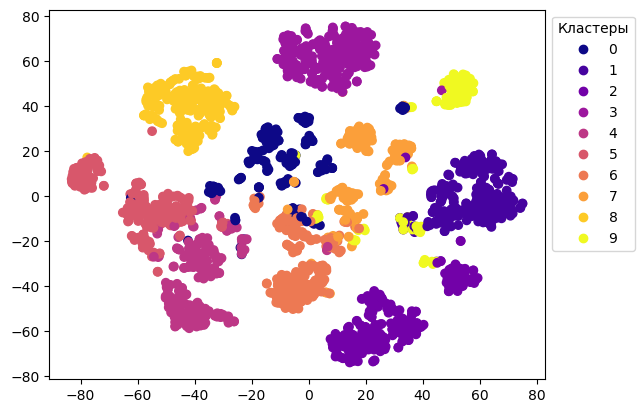

In [47]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters= 10, random_state= 42)

result = train(pre_df, model, is_show= True)

*Видим, что модель очень хорошо разделила на класстеры, предположительно категории правильно выбраны*

In [49]:
pd.DataFrame(result).to_csv('solution.csv', header=['cluster'], index=False)

# Тесты на своих размеченных данных:

In [46]:
def test(test_df:pd.DataFrame, model):
    pred_labels = train(test_df, model, ['rustitle', 'label'])
    true_labels = test_df['label'].to_list()
    h_score = homogeneity_score(true_labels, pred_labels)
    c_score = completeness_score(true_labels, pred_labels)
    print("Homogeneity Score:", h_score)
    print("Completeness Score:", c_score)
    
test(pre_test_df, model)

Homogeneity Score: 0.18013947254561488
Completeness Score: 0.16341007079986894


# Вывод:
- Видим, что не идеально, но модель что-то улавливает, попробуем понять правильно ли мы разметили данные подав решение в тесты

Результат на тесте:

![image copy.png](<attachment:image copy.png>)

Как видно мы не совсем правильно поставили метки, но правильно предположили число класстеров = 10 и наша модель смогла правильно разделить объекты по класстерам.
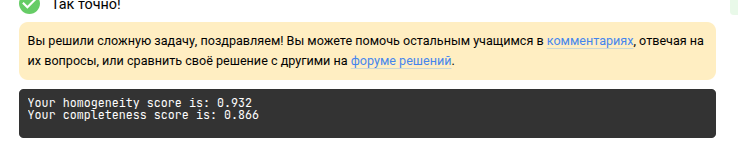